In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 18 * 18, 256)  # Assuming image size 150x150
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 18 * 18)  # Flatten the output from convolutional layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Image transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop((140, 140)),
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [2]:
# Define dataset paths
train_path = r'D:\neuralNets\Repository\ECDS-NeuralNets\Day 3\Datasets\AIorNot'
test_path = r'D:\neuralNets\Repository\ECDS-NeuralNets\Day 3\Datasets\AI_Test'

# Load the full dataset
full_dataset = datasets.ImageFolder(train_path, transform=transform)
print(f"Classes: {full_dataset.classes}")  # ['RealArt', 'AIArtData']

# Split dataset into training and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

Classes: ['AiArtData', 'RealArt']


In [3]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        correct, total, running_loss = 0, 0, 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            running_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Train and validate the model
train_model(model, train_loader, criterion, optimizer, num_epochs=5)
validate_model(model, val_loader, criterion)

d:\neuralNets\ECDS-NeuralNets\.venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5, Loss: 17.4212, Accuracy: 53.47%
Epoch 2/5, Loss: 16.6146, Accuracy: 62.98%
Epoch 3/5, Loss: 16.5276, Accuracy: 61.70%
Epoch 4/5, Loss: 16.5874, Accuracy: 60.54%
Epoch 5/5, Loss: 15.8623, Accuracy: 65.42%
Validation Loss: 4.2082, Accuracy: 64.10%


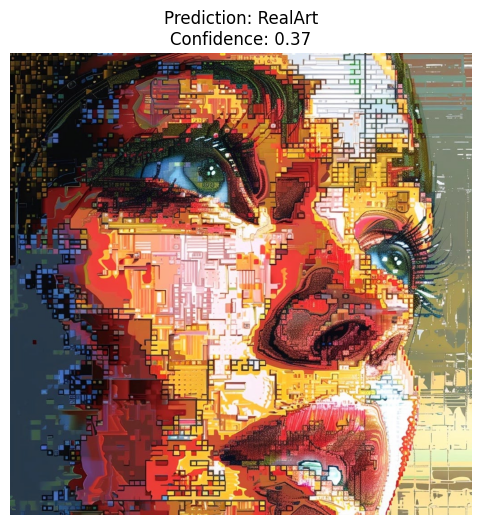

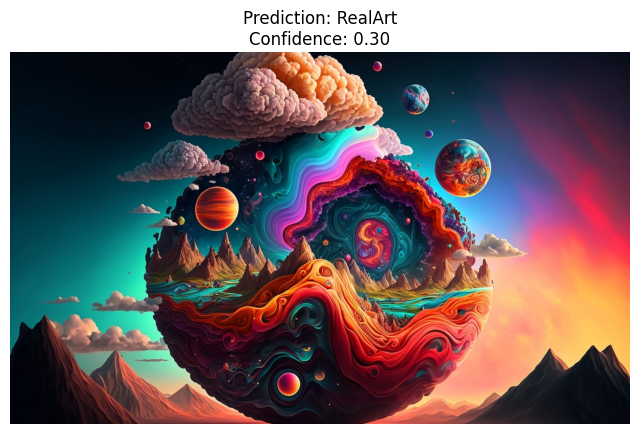

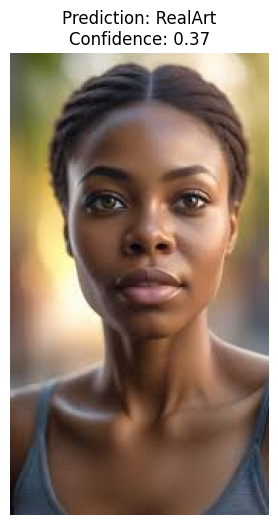

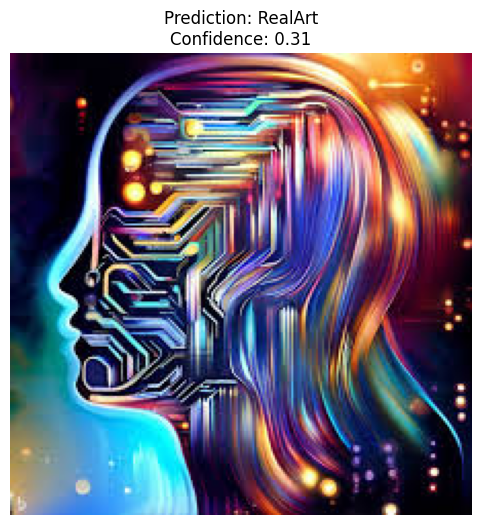

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

In [6]:
def predict_image(model, image_path):
    # Ensure the model is on the correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Open and transform the image
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)

    # Move image to the device
    image_tensor = image_tensor.to(device)

    # Set model to evaluation mode
    model.eval()

    # Predict without calculating gradients
    with torch.no_grad():
        output = model(image_tensor)
        confidence = output.item()
        prediction = 'AiArtData' if confidence >= 0.5 else 'RealArt'

    return prediction, confidence


def predict_folder(model, folder_path):
    predictions = {}
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            prediction, confidence = predict_image(model, file_path)
            predictions[filename] = {
                'class': prediction,
                'confidence': confidence
            }

            # Visualization
            plt.figure(figsize=(8, 6))
            plt.imshow(plt.imread(file_path))
            plt.axis('off')
            plt.title(f"Prediction: {prediction}\nConfidence: {confidence:.2f}")
            plt.show()

    return predictions


# Load a folder of test images and predict
test_path = r'D:\neuralNets\Repository\ECDS-NeuralNets\Day 3\Datasets\AI_Test'
predictions = predict_folder(model, test_path)

# Print detailed predictions
for image_name, result in predictions.items():
    print(f"{image_name}: Class: {result['class']}, Confidence: {result['confidence']:.4f}")

# Optional: Save the trained model
#torch.save(model.state_dict(), 'pizza_classifier.pth')